In [1]:
import bpy
import numpy as np

import os
from typing import List, Dict
from collections import deque
import bmesh

import scipy.sparse
import scipy.linalg
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

from line_profiler import profile

from mathutils import Vector, Matrix
from mathutils.bvhtree import BVHTree

np.set_printoptions(suppress=True, linewidth=150)

# install packages : "C:\Users\Pierre.Gilibert\OneDrive - ARVERNE\Bureau\blender-4.3.1-windows-x64\4.3\python\bin\python.exe" -m pip install scipy 

In [2]:
FOLDER = "C:\\Users\\pierr\\Documents\\Blender\\GeometryProcessing_Python\\"
# FOLDER = "C:\\Users\\Pierre.Gilibert\\OneDrive - ARVERNE\\Documents\\Divers\\blender"
bpy.ops.wm.open_mainfile(filepath=os.path.join(FOLDER, "blender_notebook_v02.blend"))

{'FINISHED'}

In [4]:


class HEEdge:
    def __init__(self, edge, face, orientation:int):
        self.edge = edge
        self.face = face
        self.orientation = orientation
        self.vertex = edge.verts[orientation] # orientation in {0,1} stating whether the self.edge is in the same (0) direction as self or the opposite (1) direction.
        self.next = None
        self.twin = None
        self.angle_from_X = 0.0
        self.transport_coeff = 0.0

    def __str__(self):
        return f"HEedge : {self.edge} - orientation: {self.orientation}"
    
    def __repr__(self):
        return f"HEedge : {self.edge} - orientation: {self.orientation}"

    def __getattr__(self, item):
        # Delegate attribute access to the internal bmesh instance
        return getattr(self.edge, item)

    


In [5]:

class MYMesh:
    def __init__(self):
        self.bm = bmesh.new()
        self.facecorners = []
        self.vert2facecorner = {}
        self.facecorner_attributes = {}             # facecorners attributes
        self.vertex_attributes = {"u":{}, "v":{}}   # u,v : basis vector of the tangent plane at each vertex
        self.edge_attributes = {}
        self.face_attributes = {}
        self.face_vertex_to_facecorner = {}
        self.co = None                              # A (|V|, 3) np array where row i contains the x,y,z coordinates of the vertex indexed by i 
        self.cotan = None                           # A (3|F|,) np array where entry i is the cotangent of the angle of facecorner (loop) i
        self.face_areas = None                      # A (|F|,) np array where entry i is the area for face i
        self.internal_angles = None                 # A (3|F|,) np array where entry i is the angle of facecorner (loop) i
        self.fv = None                              # A (|F|, 3) np array where row i contains the indices of the vertices of face i
        self.heedges = []                           # List of Half edges
        self.dict_vert2heedges = {}

    def from_mesh(self, mesh_data):
        """ Mimic the bmesh from_mesh function. """
        self.bm.from_mesh(mesh_data)
        self.vert2facecorner = {v:[] for v in self.verts}
        self.facecorners = []
        for face in self.faces:
            self.face_vertex_to_facecorner[face] = {}
            for loop in face.loops:
                self.vert2facecorner[loop.vert].append(loop)
                self.facecorners.append(loop)
                self.face_vertex_to_facecorner[face][loop.vert] = loop
            
        self.fv = np.array([[fc.vert.index for fc in f.loops] for f in self.faces], dtype=int) # face #f has vertex [vi, vj, vk]
        self.co = np.array([v.co for v in self.verts])
        
    def to_mesh(self, mesh_data):
        """ Mimic the bmesh to_mesh function. """
        self.bm.to_mesh(mesh_data)
    
    # Add any other bmesh methods as needed:
    def free(self):
        """ Mimic the bmesh free function. """
        self.bm.free()

    # Add a custom method to directly access the internal bmesh:
    def __getattr__(self, item):
        # Delegate attribute access to the internal bmesh instance
        return getattr(self.bm, item)
    
    def ensure_lookup_tables(self):
        self.verts.ensure_lookup_table()
        self.edges.ensure_lookup_table()
        self.faces.ensure_lookup_table()

    def create_halfedge_datastructure(self):
        self.dict_vert2heedges = {}
        self.vertex_attributes["hedge"] = {}
        # self.edge_attributes["heedges"] = {}
        # for e in self.edges:
        #     self.edge_attributes["heedges"][e] = []
        for f in self.faces:
            if len(f.verts) != 3:
                raise ValueError("Not a triangular mesh : triangulate it beforehand !!")
            v_orientation = [f.verts[0].index, f.verts[1].index, f.verts[2].index]
            face_heedges = []
            for e in f.edges:
                # e0, e1, e2 = f.edges[0], f.edges[1], f.edges[2]
                v0, v1 = v_orientation.index(e.verts[0].index), v_orientation.index(e.verts[1].index)
                orientation = 1 - ((abs(v0-v1) == 1 and v0 < v1) or (abs(v0-v1) == 2 and v0 > v1)) # 0 if the edge matches the ccw convention of the face, 1 otherwise
                # print(e, v_orientation.index(e.verts[0].index), v_orientation.index(e.verts[1].index), orientation)
                face_heedges.append(HEEdge(e, f, orientation))
            he0, he1, he2 = face_heedges
            he0.next = he1
            he1.next = he2
            he2.next = he0
            self.dict_vert2heedges[(he0.vertex.index, he1.vertex.index)] = he0
            self.dict_vert2heedges[(he1.vertex.index, he2.vertex.index)] = he1
            self.dict_vert2heedges[(he2.vertex.index, he0.vertex.index)] = he2
            self.heedges.append(he0)
            self.heedges.append(he1)
            self.heedges.append(he2)
            self.vertex_attributes["hedge"][he0.vertex] = he0
            self.vertex_attributes["hedge"][he1.vertex] = he1
            self.vertex_attributes["hedge"][he2.vertex] = he2
            # self.edge_attributes["heedges"][he0.edge] = he0
            # self.edge_attributes["heedges"][he1.edge] = he1
            # self.edge_attributes["heedges"][he2.edge] = he2

        for k in self.dict_vert2heedges:
            i0, i1 = k
            if i0 < i1:
                continue
            kr = (i1, i0)
            if kr in self.dict_vert2heedges:
                self.dict_vert2heedges[k].twin = self.dict_vert2heedges[kr]
                self.dict_vert2heedges[kr].twin = self.dict_vert2heedges[k]
        
        boundary_hedges = []
        for e in self.edges:
            if not e.is_boundary:
                continue
            i0, i1 = e.verts[0].index, e.verts[1].index
            if (i0, i1) in self.dict_vert2heedges:
                existing_he = self.dict_vert2heedges[(i0, i1)]
            elif (i1, i0) in self.dict_vert2heedges:
                existing_he = self.dict_vert2heedges[(i1, i0)]
            else:
                raise ValueError(f"Unable to find an half edge between vertices {i0} and {i1}")
            new_he = HEEdge(e, None, 1-existing_he.orientation)
            existing_he.twin = new_he
            new_he.twin = existing_he
            boundary_hedges.append(new_he)
            self.dict_vert2heedges[(new_he.vertex.index, e.other_vert(new_he.vertex).index)] = new_he
            self.heedges.append(new_he)

        # match the boundary hedges
        num_link_to_create = len(boundary_hedges)
        num_link_created = 0
        while num_link_created != num_link_to_create:
            he = boundary_hedges[num_link_created]
            # other_index = -1
            for i, ohe in enumerate(boundary_hedges):
                if ohe.vertex == he.twin.vertex:
                    other_index = i
                    break
            # ohe = boundary_hedges.pop(other_index)
            he.next = ohe
            num_link_created+=1


        # verification : all hedges should have a twin and a next defined
        for k in self.dict_vert2heedges:
            he = self.dict_vert2heedges[k]
            if he.twin is None or he.next is None:
                raise ValueError(f"Unable to define a twin or a next for hedge {k} : {he}")

    def _build_d0(self):
        row = np.repeat(np.arange(len(self.edges)), 2)
        col = np.array([y for e in self.edges for y in [e.verts[0].index, e.verts[1].index]])
        val = np.ones(len(col))
        val[0::2] = -1
        # row, col, val = [], [], []
        # for e in self.edges:
        #     row.append(e.index)
        #     row.append(e.index)
        #     vi, vj = e.verts[0].index, e.verts[1].index
        #     col.append(vi)
        #     col.append(vj)
        #     if vi < vj:
        #         val.append(-1)
        #         val.append(1)
        #     else:
        #         val.append(1)
        #         val.append(-1)

        # matrix[e] = [0,0,..., 1, 0, ..., -1, ..., 0] +1 at vertex vi, -1 at vertex vj where e = [vi, vj] in that order
        return scipy.sparse.coo_matrix((val, (row, col)), shape=(len(self.edges), len(self.verts))).tocsr()

    def _build_d1(self):
        edge_dict = {tuple([e.verts[0].index, e.verts[1].index]): i for i, e in enumerate(self.edges)}
        vi, vj, vk = self.fv[:,0], self.fv[:,1], self.fv[:,2]

        row, col, val = [], [], []
        for f in self.faces:
            vi,vj,vk = self.fv[f.index]
            edges_f = [(vi,vj), (vj,vk), (vk,vi)]
            for ef in edges_f:
                row.append(f.index)

                if ef in edge_dict: # edge viewed from face matching actual edge orientation
                    col.append(edge_dict[ef])
                    val.append(1)
                else:
                    col.append(edge_dict[(ef[1], ef[0])])
                    val.append(-1)
        # face_edges = np.reshape(np.vstack((vi, vj, vj, vk, vk, vi)).T, (len(self.faces), 3, 2))
        # # face_edges[f] = [[i,j], [j,k], [k, i]] (shape 3,2) with i,j,k the vertex indices of face f and [i,j], [j,k] and [k,i] the 3 ordered edges of face f
        # sorted_face_edges = np.sort(face_edges, axis=2)
        # val = np.any(sorted_face_edges == face_edges, axis=2)*2-1 # +1 if edge in correct orientation, -1 otherwise
        # col = np.array([edge_dict[tuple(e)] for e in sorted_face_edges.reshape((-1,2))])
        # row = np.repeat(np.arange(len(self.faces)), 3)
        # matrix[f] = [0, 0,... , +-1, ..., +-1, ..., +-1, ..., 0] non 0 at ei, ej, ek where f.edges = [ei, ej, ek] and +-1 depending on whether the vertices of the ei, ej, ek are in the sorted order or not 
        return scipy.sparse.coo_matrix((val, (row, col)), shape=(len(self.faces), len(self.edges))).tocsr()

    def _build_hodge0(self, inverse=False):
        if not "area" in self.vertex_attributes:
            self._calculate_vertex_area()
        vertex_areas = self.vertex_attributes["area"]
        N = len(self.verts)
        row = np.arange(N)
        if inverse:
            return scipy.sparse.coo_matrix((1/vertex_areas, (row, row)), shape=(N, N))
        else:
            return scipy.sparse.coo_matrix((vertex_areas, (row, row)), shape=(N, N)) # dual / primal with primal = area of vertex = 1 by convention

    def _build_hodge1(self, inverse=False):
        N = len(self.edges)
        row = np.arange(N)
        val = np.zeros(N)
        for e in self.edges:
            he = self.dict_vert2heedges[(e.verts[0].index, e.verts[1].index)]
            s = 0
            for hhe in [he, he.twin]:
                if hhe.face is None:
                    # print(hhe.edge.index)
                    continue
                vk = hhe.next.next.vertex
                fck = self.face_vertex_to_facecorner[hhe.face][vk]
                s += 0.5 * self.cotan[fck.index]

            if s == 0 and inverse:
                s = 1e-9
            val[e.index] = s
            
        if inverse:
            val = 1.0/val
        return scipy.sparse.coo_matrix((val, (row, row)), shape=(N, N))
        # edge_vertex = np.array([[e.verts[0].index, e.verts[1].index] for e in self.edges])
        # edge_face_areas = np.zeros(len(self.edges))
        # for e in self.edges:
        #     s = 0
        #     for f in e.link_faces:
        #         s += self.face_areas[f.index]
        #     edge_face_areas[e.index] = s

        # edge_len = np.linalg.norm(self.co[edge_vertex[:,1]] - self.co[edge_vertex[:,0]], axis=1)
        # # dual_edge_lengths = edge_face_areas / edge_len

        # N = len(self.edges)
        # row = np.arange(N)
        # # return edge_len / edge_face_areas
        # if inverse:
        #     return scipy.sparse.coo_matrix((edge_len / edge_face_areas, (row, row)), shape=(N, N))
        # else:
        #     return scipy.sparse.coo_matrix((edge_face_areas / edge_len, (row, row)), shape=(N, N))

    def _build_hodge2(self, inverse=False):
        if not "area" in self.vertex_attributes:
            self._calculate_vertex_area()

        N = len(self.faces)
        row = np.arange(N)
        primal_areas = self.face_areas

        dual_areas = 1 #

        # fc_area = np.array([[self.facecorner_attributes["area"][self.face_vertex_to_facecorner[f][v].index] for f in self.faces for v in f.verts]]).reshape((-1,3))
        # weights = fc_area / self.face_areas[:,None]
        # vertex_area = self.vertex_attributes["area"][self.fv.ravel()].reshape((-1,3))
        # dual_areas = weights*vertex_area
        # dual_areas = dual_areas[:,0] + dual_areas[:,1] + dual_areas[:,2]
        if inverse:
            return scipy.sparse.coo_matrix((primal_areas/dual_areas, (row, row)), shape=(N, N))
        else:
            return scipy.sparse.coo_matrix((dual_areas/primal_areas, (row, row)), shape=(N, N))

    def construct_dec_operators(self, inverse_hodge0=False, inverse_hodge1=False, inverse_hodge2=False):
        """
        Constructs discrete exterior derivative operators (d0, d1) and
        Hodge star matrices (hodge0, hodge1, hodge2).
        """
        d0 = self._build_d0()
        d1 = self._build_d1()
        hodge0 = self._build_hodge0(inverse=inverse_hodge0)
        hodge1 = self._build_hodge1(inverse=inverse_hodge1)
        hodge2 = self._build_hodge2(inverse=inverse_hodge2)
        
        return d0, d1, hodge0, hodge1, hodge2

    def vector_field_to_1form(self, vector_field):
        """
        Projects a vertex-based tangent vector field onto a discrete 1-form on edges.

        Parameters:
        - vector_field: Nx3 numpy array, the tangent vector field at each vertex.

        Returns:
        - one_form: Mx1 numpy array, the discrete 1-form (edge-based representation).
        """
        
        edge_vertex = np.array([[e.verts[0].index, e.verts[1].index] for e in self.edges])
        edge_dir = self.co[edge_vertex[:,1]] - self.co[edge_vertex[:,0]]
        ui = vector_field[edge_vertex[:,0]]
        uj = vector_field[edge_vertex[:,1]]
        u_edge = 0.5 * (ui+uj)
        dot = np.einsum('ij,ij->i', u_edge, edge_dir) # fast dot product 
        return dot#/np.linalg.norm(edge_dir, axis=1)
    
    def one_form_to_vector_field(self, one_form):

        row, col, val = [], [], []
        b = 2*one_form.copy()

        n_row = 0
        for e in self.edges:
            vi, vj = e.verts[0].index, e.verts[1].index
            vec = e.verts[1].co - e.verts[0].co
            vec = vec#/np.linalg.norm(vec)
            # dot((ui + uj)/2, vec) = one_form[e77.index]
            row.extend([e.index, e.index, e.index, e.index, e.index, e.index])
            col.extend([3*vi+0, 3*vi+1, 3*vi+2, 3*vj+0, 3*vj+1, 3*vj+2])
            val.extend([vec[0], vec[1], vec[2], vec[0], vec[1], vec[2]])
            n_row+=1

        # ensure solution is in the tangent plane
        for v in self.verts:
            row.extend([n_row + v.index, n_row + v.index, n_row + v.index])
            col.extend([3*v.index + 0, 3 * v.index + 1,  3 * v.index + 2])
            n = np.array(v.normal)
            val.extend([n[0], n[1], n[2]])

        b = np.hstack((b, np.zeros(len(self.verts))))
        
        A = scipy.sparse.coo_matrix((val, (row, col))).tocsr()

        res=spsolve(A.T@A + scipy.sparse.eye(A.shape[1])*1e-9, A.T@b)
        res = res.reshape((-1,3))
        return res

    def _calculate_corner_area(self):
        if self.internal_angles is None:
            self._calculate_corner_angles_and_face_areas()

        nfaces = len(self.faces)
        ffc = np.arange(3*nfaces).reshape((nfaces, 3)) # face corner index : face #f has corners [i, j, k];
        angles = self.internal_angles[ffc] # array of alpha_i, alpha_j, alpha_k
        eij = self.co[self.fv[:,1]] - self.co[self.fv[:,0]] # edges
        ejk = self.co[self.fv[:,2]] - self.co[self.fv[:,1]]
        eki = self.co[self.fv[:,0]] - self.co[self.fv[:,2]]
        lij2 = eij[:,0]*eij[:,0] + eij[:,1]*eij[:,1] + eij[:,2]*eij[:,2] # squared lengths of the edges
        ljk2 = ejk[:,0]*ejk[:,0] + ejk[:,1]*ejk[:,1] + ejk[:,2]*ejk[:,2]
        lki2 = eki[:,0]*eki[:,0] + eki[:,1]*eki[:,1] + eki[:,2]*eki[:,2]

        # in case triangle i,j,k is non obtuse (all its angles are < pi/2) then this is the area of each face corner
        non_obtuse_area_i = 0.125 * (lij2 * self.cotan[ffc[:,2]] + lki2 * self.cotan[ffc[:,1]])
        non_obtuse_area_j = 0.125 * (ljk2 * self.cotan[ffc[:,0]] + lij2 * self.cotan[ffc[:,2]])
        non_obtuse_area_k = 0.125 * (lki2 * self.cotan[ffc[:,1]] + ljk2 * self.cotan[ffc[:,0]])

        facecorners_areas = np.zeros(3*nfaces).reshape((nfaces, 3))
        # check whether the angles are less than pi/2
        small_angle_bool = angles < np.pi/2
        big_angle_bool = ~small_angle_bool
        # True for all corners of triangle i,j,k ==> use the non_obtuse_area
        non_obtuse_bool = np.logical_and(small_angle_bool[:,0], np.logical_and(small_angle_bool[:,1], small_angle_bool[:,2]))
        facecorners_areas[non_obtuse_bool, 0] = non_obtuse_area_i[non_obtuse_bool]
        facecorners_areas[non_obtuse_bool, 1] = non_obtuse_area_j[non_obtuse_bool]
        facecorners_areas[non_obtuse_bool, 2] = non_obtuse_area_k[non_obtuse_bool]
        # False for corner p in {i,j,k}: use half the face area for p and a quarter for the two others corners
        facecorners_areas[big_angle_bool[:,0]] = self.face_areas[big_angle_bool[:,0]][:,None] * np.array([[0.5, 0.25, 0.25]])
        facecorners_areas[big_angle_bool[:,1]] = self.face_areas[big_angle_bool[:,1]][:,None] * np.array([[0.25, 0.5, 0.25]])
        facecorners_areas[big_angle_bool[:,2]] = self.face_areas[big_angle_bool[:,2]][:,None] * np.array([[0.25, 0.25, 0.5]])

        self.facecorner_attributes["area"] = facecorners_areas.ravel()

    def _calculate_corner_angles_and_face_areas(self):

        vi = self.co[self.fv[:,0]]
        vj = self.co[self.fv[:,1]]
        vk = self.co[self.fv[:,2]]

        eij, ejk, eki = vj-vi, vk-vj, vi-vk
        lij2 = eij[:,0]*eij[:,0] + eij[:,1]*eij[:,1] + eij[:,2]*eij[:,2]
        ljk2 = ejk[:,0]*ejk[:,0] + ejk[:,1]*ejk[:,1] + ejk[:,2]*ejk[:,2]
        lki2 = eki[:,0]*eki[:,0] + eki[:,1]*eki[:,1] + eki[:,2]*eki[:,2]
        lij, ljk, lki = np.sqrt(lij2), np.sqrt(ljk2), np.sqrt(lki2)

        s = 0.5 * (lij + ljk + lki) # half perimeter of every triangle
        self.face_areas = np.sqrt(s * (s - lij) * (s - ljk) * (s - lki)) # Heron's formula for the area of the triangles
        
        q_i = -ljk2 + lij2 + lki2
        q_j = -lki2 + ljk2 + lij2
        q_k = -lij2 + lki2 + ljk2

        denom_inv = 1/(4*self.face_areas)
        self.cotan = np.zeros(3*len(bm.faces))
        self.cotan[0::3] = q_i*denom_inv
        self.cotan[1::3] = q_j*denom_inv
        self.cotan[2::3] = q_k*denom_inv

        self.internal_angles = np.zeros(3*len(bm.faces))
        self.internal_angles[0::3] = np.arccos(np.clip(q_i / (2*lij * lki), -1, 1))
        self.internal_angles[1::3] = np.arccos(np.clip(q_j / (2*ljk * lij), -1, 1))
        self.internal_angles[2::3] = np.arccos(np.clip(q_k / (2*lki * ljk), -1, 1))

    def _calculate_vertex_area(self, force_recompute=False):
        # self.vertex_attributes["area"] = np.array([np.sum([self.facecorner_attributes["area"][fc.index] for fc in self.vert2facecorner[v]]) for v in self.verts])
        if not "area" in self.facecorner_attributes or force_recompute:
            self._calculate_corner_area()
            
        val = []
        for v in self.verts:
            s = 0
            for fc in self.vert2facecorner[v]:
                s += self.facecorner_attributes["area"][fc.index]
            val.append(s)
        self.vertex_attributes["area"] = np.array(val)
      
    def assign_distinguished_vector_X(self):
        all_X = []
        for v in self.verts:
            if v.is_boundary:
                boundary_edges = [e for e in v.link_edges if e.is_boundary]
                if len(boundary_edges) != 2:
                    raise ValueError(f"Non manifold mesh : vertex {v.index} does not have exactly 2 adjacent boundary edges")
                other_vs = [boundary_edges[0].other_vert(v), boundary_edges[1].other_vert(v)]
                # select the hedge starting at v and having a non None face
                vector_X = None
                for ov in other_vs:
                    key = (v.index, ov.index)
                    key_r = (ov.index, v.index)
                    for k in [key, key_r]:
                        he = self.dict_vert2heedges[k]
                        if he.vertex == v and he.face is not None:
                            vector_X = he
                            break
                    if vector_X is not None:
                        break
                if vector_X is None:
                    raise ValueError(f"Unable to find an X for boundary vertex {v.index}")
                all_X.append(vector_X)
                # if (v.index, boundary_edges[0].other_vert(v).index) in self.dict_vert2heedges:
                #     all_X.append(self.dict_vert2heedges[(v.index, boundary_edges[0].other_vert(v).index)])
                # elif (v.index, boundary_edges[1].other_vert(v).index) in self.dict_vert2heedges:
                #     all_X.append(self.dict_vert2heedges[(v.index, boundary_edges[1].other_vert(v).index)])
                # else:
                #     raise ValueError(f"Unable to find an X for boundary vertex {v.index}")
            else:
                all_X.append(self.dict_vert2heedges[(v.index, v.link_edges[0].other_vert(v).index)])
        # all_X = np.array(all_X)
        self.vertex_attributes["X"] = all_X 

    def calculate_angle_sum(self, force_recompute=False):
        if self.internal_angles is None or force_recompute:
            self._calculate_corner_angles_and_face_areas()
        angle_sum = np.zeros(len(self.verts))
        for i, v in enumerate(self.verts):
            s = 0
            for fc in self.vert2facecorner[v]:
                s += self.internal_angles[fc.index]
            angle_sum[i] = s

        self.vertex_attributes["angle_sum"] = angle_sum

    def calculate_angle_defect(self, force_recompute=False):
        if not "angle_sum" in self.vertex_attributes or force_recompute:
            self.calculate_angle_sum(force_recompute)

        boundary_coeff =  2 - np.array([v.is_boundary for v in self.verts]) # v on interior : 2 ; v on boundary : 1
        self.vertex_attributes["angle_defect"] = np.pi * boundary_coeff - self.vertex_attributes["angle_sum"]

    def calculate_gaussian_curvature(self, force_recompute=False):
        if not "area" in self.vertex_attributes or force_recompute:
            self._calculate_vertex_area(force_recompute)
        if not "angle_defect" in self.vertex_attributes or force_recompute:
            self.calculate_angle_defect(force_recompute)

        self.vertex_attributes["gaussian_curvature"] = self.vertex_attributes["angle_defect"] / self.vertex_attributes["area"]

    def compute_face_frame(self):

        vi, vj, vk = self.co[self.fv[:,0]], self.co[self.fv[:,1]], self.co[self.fv[:,2]]
        e1 = vj - vi
        e1 = e1 / np.linalg.norm(e1, axis=1)[:,None]
        e2 = vk - vi
        e2 = e2 - e1 * np.einsum('ij,ij->i',e1, e2)[:,None]
        e2 = e2/np.linalg.norm(e2, axis=1)[:,None]

        self.face_attributes["e1"] = e1
        self.face_attributes["e2"] = e2

    def shared_halfedge(self, f, g):
        vi, vj = f.verts[0].index, f.verts[1].index
        he:HEEdge
        he = self.dict_vert2heedges[(vi, vj)]
        keep_looping = True
        while keep_looping:
            if he.twin.face == g:
                return he
            he = he.next
            keep_looping = he != self.dict_vert2heedges[(vi,vj)]
        raise ValueError(f"Unable to find a common halfedge between faces {f.index} and {g.index}")
      


In [60]:
# obj = bpy.data.objects["Sphere"]
obj = bpy.data.objects["Plane"]
obj = bpy.data.objects["Bunny"]

bpy.ops.object.mode_set(mode='OBJECT')
mesh = obj.data
bm = MYMesh()
bm.from_mesh(mesh)
bm.ensure_lookup_tables()
bm.create_halfedge_datastructure()
bm._calculate_corner_angles_and_face_areas()
bm.compute_face_frame()

In [7]:

class MyBezier:
    def __init__(self, spline):
        self.spline = spline


    def _retrieve_segment_and_local_coordinate_at(self, t):
        # Ensure t is within [0, 1]
        t = max(0.0, min(1.0, t))

        # Total number of segments (n - 1 control points)
        n_segments = len(self.spline.bezier_points) - 1
        if n_segments < 1:
            raise ValueError("The spline must have at least two bezier points.")

        # Determine which segment the parameter t falls into
        segment_index = int(t * n_segments)
        segment_index = min(segment_index, n_segments - 1)  # Clamp to valid index

        # Compute local parameter s in the segment
        s = (t - segment_index / n_segments) * n_segments

        # Retrieve the control points for the segment
        pA = self.spline.bezier_points[segment_index].co
        hA = self.spline.bezier_points[segment_index].handle_right
        pB = self.spline.bezier_points[segment_index + 1].co
        hB = self.spline.bezier_points[segment_index + 1].handle_left
        return s, pA, hA, pB, hB


    def evaluate(self, t):
        """
        Evaluate the position on the Bezier curve at parameter t (0 <= t <= 1).

        Parameters:
        t (float): A parameter between 0 and 1.

        Returns:
        Vector: The 3D coordinate of the point at t.
        """
        s, pA, hA, pB, hB = self._retrieve_segment_and_local_coordinate_at(t)

        # Compute p(s) using the cubic Bezier formula
        p_s = ((1 - s) ** 3) * pA + \
              3 * ((1 - s) ** 2) * s * hA + \
              3 * (1 - s) * (s ** 2) * hB + \
              (s ** 3) * pB

        return p_s


    def evaluate_derivative(self, t):
        """
        Compute the tangent (derivative) of the Bezier curve at parameter t.

        Parameters:
        t (float): A parameter between 0 and 1.

        Returns:
        Vector: The 3D tangent vector at t.
        """
        s, pA, hA, pB, hB = self._retrieve_segment_and_local_coordinate_at(t)
        p_prime_s = -3 * ((1 - s) ** 2) * pA + \
                     3 * ((1 - s) ** 2 - 2 * (1 - s) * s) * hA + \
                     3 * (2 * (1 - s) * s - s ** 2) * hB + \
                     3 * (s ** 2) * pB
        return p_prime_s.normalized()


class MyNurbs:
    def __init__(self, spline):
        self.spline = spline

    def evaluate(self, t):
        """Evaluate the NURBS curve at parameter t (0 <= t <= 1)."""
        points = [p.co for p in self.spline.points]
        weights = [p.weight for p in self.spline.points]
        n = len(points) - 1

        # Calculate the basis functions (B-splines)
        def basis(i, k, t):
            if k == 0:
                return 1.0 if i / n <= t <= (i + 1) / n else 0.0
            else:
                left = ((t - i / n) / (k / n)) * basis(i, k - 1, t) if k / n > 0 else 0
                right = (((i + k + 1) / n - t) / (k / n)) * basis(i + 1, k - 1, t) if k / n > 0 else 0
                return left + right

        # Evaluate curve
        numerator = sum(weights[i] * points[i] * basis(i, self.spline.order_u, t) for i in range(n + 1))
        denominator = sum(weights[i] * basis(i, self.spline.order_u, t) for i in range(n + 1))
        return numerator / denominator if denominator != 0 else Vector((0, 0, 0))

    def evaluate_derivative(self, t):
        """Compute the tangent at parameter t."""
        delta_t = 0.001
        p0 = self.evaluate(max(0, t-delta_t))
        p1 = self.evaluate(t)
        p2 = self.evaluate(min(1.0, t + delta_t))
        return (p2 - p1).normalized()


class MyPoly:
    def __init__(self, spline):
        self.spline = spline

    def evaluate(self, t):
        """Evaluate a polyline at parameter t."""
        points = [p.co for p in self.spline.points]
        segment_count = len(points) - 1
        segment_index = min(int(t * segment_count), segment_count - 1)
        segment_t = (t * segment_count) - segment_index
        return (1 - segment_t) * points[segment_index] + segment_t * points[segment_index + 1]

    def evaluate_derivative(self, t):
        """Compute the tangent of a polyline."""
        points = [p.co for p in self.spline.points]
        segment_count = len(points) - 1
        segment_index = min(int(t * segment_count), segment_count - 1)
        return (points[segment_index + 1] - points[segment_index]).normalized()


def wrap_spline(spline):
    """Wrap a spline object in the appropriate class."""
    if spline.type == 'BEZIER':
        return MyBezier(spline)
    elif spline.type == 'NURBS':
        return MyNurbs(spline)
    elif spline.type == 'POLY':
        return MyPoly(spline)
    else:
        raise ValueError(f"Unsupported spline type: {spline.type}")


In [8]:
class LineLineIntersect3D:        
    def __init__(self, p1, p2, p3, p4):
        """                                                                                                                       <-->     <-->
            Calculate the points in 3D space Pa and Pb that define the line segment which is the shortest route between two lines p1p2 and p3p4.
            Each point occurs at the apparent intersection of the 3D lines.
            The apparent intersection is defined here as the location where the two lines 'appear' to intersect when viewed along the line segment PaPb.
            Equation for each line:
            Pa = p1 + ma(p2-p1)
            Pb = p3 + mb(p4-p3)
            
            Pa lies on the line connecting p1p2.
            Pb lies on the line connecting p3p4.

            The shortest line segment is perpendicular to both lines. Therefore:
            (Pa-Pb).(p2-p1) = 0
            (Pa-Pb).(p4-p3) = 0

            Where:            
            '.' indicates the dot product            

            A = p1-p3
            B = p2-p1
            C = p4-p3

            Substituting:
            (A + ma(B) - mb(C)).B = 0       &       (A + ma(B) - mb(C)).C = 0
            -----------------------------------------------------------------
            A.B + ma(B.B) - mb(C.B) = 0
            A.B + ma(B.B) - (ma(C.B)-A.C)/C.C)(C.B) = 0
            ma(B.B)(C.C) - ma(C.B)(C.B) = (A.C)(C.B)-(A.B)(C.C)
            ma = ((A.C)(C.B)-(A.B)(C.C))/((B.B)(C.C) - (C.B)(C.B))
            mb = (A.B + ma(B.B))/(C.B)

            If the cross product magnitude of the two lines is equal to 0.0, the lines are parallel.          
                                                                                                                                                 <-->
            A line extends forever in both directions. The name of a line passing through two different points p1 and p2 would be "line p1p2" or p1p2.                                           
            The two-headed arrow over p1p2 signifies a line passing through points p1 and p2.

            Two lines which have no actual intersection but are not parallel are called 'skew' or 'agonic' lines. Skew lines can only exist in
            three or more dimensions.

            Determine whether the apparent intersection point lies between the line segment end points or beyond one of the line segment end points.
            This information is to be used to evaluate the framing condition of mem1 (p1p2).
            Convention for members:
                p1p2 - mem1.left.location, mem1.right.location
                p3p4 - mem2.left.location, mem2.right.location
                
            Set a keyword indicating the apparent intersection point position with respect to the line segment end points p1 and p2 as follows:
                'LE' indicates the apparent intersection point occurs at p1 (within fudge_factor distance)
                'RE' indicates the apparent intersection point occurs at p2 (within fudge_factor distance)
                'Beyond LE' indicates the apparent intersection point occurs beyond p1
                'Beyond RE' indicates the apparent intersection point occurs beyond p2
                'Not Beyond LE' indicates the apparent intersection point occurs in between p1 and p2 and is closer to p1
                'Not Beyond RE' indicates the apparent intersection point occurs in between p1 and p2 and is closer to p2
            Calculate the magnitude and direction (beam member 'X' distance) the apparent intersection point occurs from line segment p1p2 end points.
        """
        def cross_product(p1, p2):
            return np.array([p1[1]*p2[2] - p1[2]*p2[1], p1[2]*p2[0] - p1[0]*p2[2], p1[0]*p2[1] - p1[1]*p2[0]])

        def dot_product(p1, p2):
            return p1[0]*p2[0] + p1[1]*p2[1] + p1[2]*p2[2]

        def mag(p):
            return np.sqrt(p[0]*p[0] + p[1]*p[1] + p[2]*p[2])        

        def normalise(p1, p2):
            p = p2 - p1
            m = mag(p)
            if m == 0:
                return np.zeros(3)
            else:
                return p / m

        A = p1-p3
        B = p2-p1
        C = p4-p3

        # Line p1p2 and p3p4 unit vectors
        self.uv1 = normalise(p1, p2)
        self.uv2 = normalise(p3, p4)        

        # Check for parallel lines
        self.cp12 = cross_product(self.uv1, self.uv2)
        self._cp12_ = mag(self.cp12)

        if round(self._cp12_, 6) != 0.0:         
            ma = ((dot_product(A, C)*dot_product(C, B)) - (dot_product(A, B)*dot_product(C, C)))/ \
                 ((dot_product(B, B)*dot_product(C, C)) - (dot_product(C, B)*dot_product(C, B)))
            mb = (ma*dot_product(C, B) + dot_product(A, C))/ dot_product(C, C)

            
            # Calculate the point on line 1 that is the closest point to line 2
            Pa = p1 + B * ma
            self.Pmem1 = Pa
            
            # Calculate the point on line 2 that is the closest point to line 1
            Pb = p3 + C * mb
            self.Pmem2 = Pb
            
            # Distance between lines            
            self.inters_dist = np.linalg.norm(Pa - Pb)
            if round(ma, 3) >= 0.0 and round(ma, 3) <= 1.0:
                self.on_segment1 = 1
                xl_dir = 1
                xr_dir = -1
                if round(ma, 2) == 0.0:
                    self.position = "LE" # apparent intersection is at p1
                elif round(ma, 2) == 1.0:
                    self.position = "RE" # apparent intersection is at p2
                    xr_dir = 1
                    xl_dir = 1
                elif ma <= 0.5:
                    self.position = "Not Beyond LE" # apparent intersection is closer to p1
                elif ma > 0.5:
                    self.position = "Not Beyond RE" # apparent intersection is closer to p2
                else:
                    raise ValueError('self.position calculation error, self.on_segment = 1')
            else:
                self.on_segment1 = 0
                if ma < 0.0:
                    self.position = "Beyond LE" # apparent intersection is beyond p1
                    xl_dir = -1
                    xr_dir = -1
                elif ma > 0.0:
                    self.position = "Beyond RE" # apparent intersection is beyond p2
                    xl_dir = 1
                    xr_dir = 1
                else:
                    raise ValueError('self.position calculation error, self.on_segment = 0')

            # Set the member 'X' direction with respect to p1 and p2 - either '+' or '-'
            self.left_dist = round(mag(p1 - Pa)*xl_dir, 8)
            self.right_dist = round(mag(p2 - Pa)*xr_dir, 8)                

            if round(mb, 3) >= 0.0 and round(mb, 3) <= 1.0:
                self.on_segment2 = 1
            else:
                self.on_segment2 = 0
            
            # Calculate the unit vector of PaPb
            if round(self.inters_dist, 4) > 0.0:
                self.uv = normalise(Pb, Pa)
            else:
                self.uv = np.zeros(3)
                
        # Lines are parallel
        else:
            self.Pmem1 = None
            self.Pmem2 = None
            self.inters_dist = None
            self.left_dist = None
            self.right_dist = None
            self.uv = None

    # Return False if lines are parallel, and return True if lines are not parallel        
    def not_parallel(self):
        if round(self._cp12_, 5) != 0.0:
            return True
        else:
            return False 
# end class definition





In [8]:
    
def load_guide_curves(collection_name):
    """
    Load all Bezier curves from the specified collection.

    Parameters:
    collection_name (str): The name of the collection containing the Bezier curves.

    Returns:
    list: A list of curve objects (bpy.types.Curve) representing the Bezier curves.
    """
    curves = []
    
    # Get the collection
    if collection_name in bpy.data.collections:
        collection = bpy.data.collections[collection_name]
        
        # Iterate through objects in the collection
        for obj in collection.objects:
            if obj.type == 'CURVE':             
                curves.append(obj)
    else:
        print(f"Collection '{collection_name}' not found.")
    
    return curves

def curve_2_polyline(curve, sampling_step):
    """
    Discretize a curve into a polyline by sampling points along its length.

    Parameters:
    curve (bpy.types.Object): The curve object to discretize.
    sampling_step (float): The distance between sampled points.

    Returns:
    list: A list of tuples, each containing (point, tangent), where:
          - point (Vector): The position of the sampled point.
          - tangent (Vector): The tangent at the sampled point.
    """
    polyline = []

    if curve.type != 'CURVE':
        raise ValueError("Provided object is not a curve.")

    # Iterate through splines in the curve
    for spline in curve.data.splines:
        # print(spline.bezier_points)
        for ii, p in enumerate(spline.bezier_points):
            draw_sphere(p.co, 0.005, f"bezier_{ii}")
            # print(p.handle_left, p.handle_right, p.co)
        wrapped_spline = wrap_spline(spline)

        # Estimate the number of points based on spline length
        total_length = spline.calc_length()  # Length of the spline
        num_points = max(2, int(total_length / sampling_step))  # Number of points

        # Generate sampled points along the curve
        for i in range(num_points):
            t = i / (num_points - 1)  # Parameter along the curve (0 to 1)
            point = wrapped_spline.evaluate(t)
            # tangent = wrapped_spline.evaluate_derivative(t)

            # Transform point and tangent to world coordinates
            point_world = curve.matrix_world @ point
            # tangent_world = curve.matrix_world.to_3x3() @ tangent

            polyline.append(point_world)

    return polyline

def polyline_to_mesh(polyline_pts, tangents, name="PolylineMesh"):
    """
    Create a Blender mesh object from a polyline.

    Parameters:
    polyline_pts (list of [Vector]): A list of [point] where:
    tangents (list of [Vector]): A list of [tangent] where:
                                         - point (Vector): A 3D coordinate.
                                         - tangent (Vector): A 3D tangent vector 
    name (str): The name of the created mesh object.

    Returns:
    bpy.types.Object: The created mesh object.
    """

    if len(polyline_pts) < 2:
        raise ValueError("Polyline must contain at least two points.")

    # Extract points from the polyline
    # points = [p[0] for p in polyline]
    # tangents = [p[1] for p in polyline]

    # Create a new mesh and object
    mesh = bpy.data.meshes.new(name)
    obj = bpy.data.objects.new(name, mesh)

    # Link the object to the current collection
    bpy.context.collection.objects.link(obj)

    # Create the mesh data
    mesh.from_pydata(polyline_pts, [(i, i + 1) for i in range(len(polyline_pts) - 1)], [])

    if 'tangent_at_p' in mesh.attributes:
        mesh.attributes.remove(mesh.attributes["tangent_at_p"])

    attr = mesh.attributes.new(name="tangent_at_p", type='FLOAT_VECTOR', domain='POINT')
    attr.data.foreach_set('vector', np.array(tangents).flatten())

    # Update the mesh to ensure it displays correctly in Blender
    mesh.update()
    
    return obj

def ensure_helpers_collection():
    """
    Ensure that a collection named "Helpers" exists in the scene.
    Returns the "Helpers" collection.
    """
    if "Helpers" not in bpy.data.collections:
        helpers_collection = bpy.data.collections.new("Helpers")
        bpy.context.scene.collection.children.link(helpers_collection)
    return bpy.data.collections["Helpers"]


def draw_cylinder(pstart, pend, radius, name="Helper_Cylinder"):
    """
    Draw a cylinder using Blender's bmesh module.

    Parameters:
    pstart (Vector): The center of the bottom circular face.
    pend (Vector): A point on the center of the top circular face.
    radius (float): The radius of the cylinder.

    Returns:
    The Blender object representing the cylinder.
    """
    # Delete all objects named "Cylinder" in the scene
    for obj in bpy.data.objects:
        if obj.name == name:
            bpy.data.objects.remove(obj, do_unlink=True)
    # Calculate the cylinder's length (height) and direction vector
    pstart, pend = np.array(pstart), np.array(pend)
    direction = pend - pstart
    height = np.linalg.norm(direction)

    # Normalize the direction vector
    direction = direction / height

    # Create a new mesh and object for the cylinder
    mesh = bpy.data.meshes.new(name)
    obj = bpy.data.objects.new(name, mesh)
    # bpy.context.collection.objects.link(obj)
    # Add the object to the "Helpers" collection
    helpers_collection = ensure_helpers_collection()
    helpers_collection.objects.link(obj)

    # Create a bmesh object to define geometry
    bm = bmesh.new()
    bmesh.ops.create_cone(
        bm,
        cap_ends=True,
        segments=16,
        radius1=radius,
        radius2=radius/4,
        depth=height
    )

    # Apply a transformation matrix to orient the cylinder
    # Align the cylinder along the specified axis
    up = np.array([0,0,1])
    rot_axis = np.cross(up, direction) #up.cross(direction)
    rot_axis_len = np.linalg.norm(rot_axis)
    if rot_axis_len > 0:  # Ensure the rotation axis is valid
        rot_axis = rot_axis / rot_axis_len
        angle = np.arccos(direction[2]) # np.arccos(np.dot(up, direction)) #up.angle(direction)
        rot_matrix = Matrix.Rotation(angle, 4, rot_axis)

        bmesh.ops.rotate(bm, verts=bm.verts, cent=(0, 0, 0), matrix=rot_matrix)

    # Translate the cylinder to the starting position
    translation = bmesh.ops.translate(bm, verts=bm.verts, vec=(pstart+pend)/2)

    # Write the bmesh data to the mesh
    bm.to_mesh(mesh)
    bm.free()


def draw_sphere(centre, radius, name):
    """
    Draw a sphere using Blender's bmesh module.

    Parameters:
    centre (Vector): The center of the sphere.
    radius (float): The radius of the sphere.

    Returns:
    The Blender object representing the sphere.
    """
    # Delete all objects named "Sphere" in the scene
    for obj in bpy.data.objects:
        if obj.name == name:
            bpy.data.objects.remove(obj, do_unlink=True)

    # Create a new mesh and object for the sphere
    mesh = bpy.data.meshes.new(name)
    obj = bpy.data.objects.new(name, mesh)
    # bpy.context.collection.objects.link(obj)
    # Add the object to the "Helpers" collection
    helpers_collection = ensure_helpers_collection()
    helpers_collection.objects.link(obj)

    # Create a bmesh object to define geometry
    bm = bmesh.new()
    bmesh.ops.create_uvsphere(
        bm,
        u_segments=4,
        v_segments=4,
        radius= radius
    )

    # Translate the sphere to the specified center
    bmesh.ops.translate(bm, verts=bm.verts, vec=centre)

    # Write the bmesh data to the mesh
    bm.to_mesh(mesh)
    bm.free()

    return obj


def project_polyline_to_mesh(polyline, mesh:MYMesh):
    """
    Project a polyline onto the surface of a given mesh.

    Parameters:
    polyline (list of Vector): The input polyline (a list of 3D points).
    mesh (MYMesh): The mesh object onto which the polyline will be projected.

    Returns:
    list of Vector: The projected polyline points.
    """
    
    mesh.bm.normal_update()
    bvh_tree = BVHTree.FromBMesh(mesh.bm)
    # bm.free()
    # Compute the parameter of each point of the polyline
    cum_dist = np.zeros(len(polyline))
    for i, point in enumerate(polyline):
        if i == 0:
            continue

        p_other = polyline[i-1]
        d = np.linalg.norm(point - p_other)
        cum_dist[i] = cum_dist[i-1] + d

    parameters = cum_dist / cum_dist[-1]

    # Project each polyline point onto the mesh
    # SPHEREINDEX = 0
    results = []
    projected_polyline = []
    face_indices = []
    for ip, point in enumerate(polyline):
        point = np.array(point)
        # Find the nearest face index on the mesh surface
        location, _, index, _ = bvh_tree.find_nearest(point)
        # if location is not None:
        #     projected_polyline.append(location)
        #     face_indices.append(index)
        # else:
        #     # If no projection is found (rare case), use the original point
        #     # projected_polyline.append(point)
        #     pass

        if location is not None:
            face = mesh.faces[index]
            # find the segments of the polyline on both side of the current point
            segments = []
            if ip == 0:
                p_other = np.array(polyline[ip+1])
                segments.append([ip, ip+1, point, p_other]) # index and points
            elif ip == len(polyline) - 1:
                p_other = np.array(polyline[ip-1])
                segments.append([ip-1, ip, p_other, point])
            else:
                p_other = np.array(polyline[ip-1])
                segments.append([ip-1, ip, p_other, point])
                p_other = np.array(polyline[ip+1])
                segments.append([ip, ip+1, point, p_other])
            # intersect with the three edges of that face:
            for edge in face.edges:
                p1, p2 = np.array(edge.verts[0].co), np.array(edge.verts[1].co)
                for seg in segments:
                    lxl = LineLineIntersect3D(seg[2], seg[3], p1, p2) # seg[2], seg[3] = points
                    if lxl.on_segment2 and lxl.on_segment1: # intersection on both segments
                        left_param, right_param = parameters[seg[0]], parameters[seg[1]]

                        if right_param < left_param: # should not happen
                            raise ValueError("Invalid point ordering")
                        
                        dist_to_p1 =  np.linalg.norm(lxl.Pmem1  - seg[2])
                        seg_length = np.linalg.norm(seg[3] - seg[2])
                        pmem1_param = left_param + (dist_to_p1 / seg_length) * (right_param - left_param)

                        # only add the result if the point on edge is far enough from the previous point (or if this is the first point)
                        if (len(results) == 0) or (len(results)>0 and np.linalg.norm(lxl.Pmem2 - results[-1][2]) > 1e-6) : 
                                results.append([pmem1_param, lxl.Pmem1, lxl.Pmem2, edge.index]) # parameter on the polyline, point on original line segment of polyline, point on edge, edge index

                        # draw_cylinder(lxl.Pmem1, lxl.Pmem2, 0.0005, name=f"lxl_{SPHEREINDEX}")
                        # SPHEREINDEX += 1

    # sort by increasing parameter
    sorted_index = np.argsort([p[0] for p in results])
    sorted_project_polyline = np.array([results[i][2] for i in sorted_index])
    edge_indices = np.array([results[i][3] for i in sorted_index])
                    
    return sorted_project_polyline, edge_indices

def resample_polyline_1_point_per_face(polyline, face_indices):
    """
    Resample the polyline to ensure there is only one point per face.

    Parameters:
    polyline (list of Vector): The projected polyline (points on the mesh).
    face_indices (list of int): The indices of the faces the polyline points were projected onto.

    Returns:
    list of Vector: The resampled polyline with one point per face.
    """
    resampled_polyline = []
    visited_faces = []  # Track faces that have already contributed a point
    for i, face_index in enumerate(face_indices):
        if face_index not in visited_faces:
            visited_faces.append(face_index)  # Mark this face as visited
            resampled_polyline.append(polyline[i])  # Add the corresponding point
    return resampled_polyline, visited_faces

def get_tangent(polyline):
    """
    Calculate the tangent vectors for each point in the polyline.

    Parameters:
    polyline (list of Vector): The polyline points.

    Returns:
    list of Vector: The tangent vectors at each point.
    """
    tangents = []

    for i in range(len(polyline)):
        if i == 0:
            # Forward difference for the first point
            tangent = polyline[i + 1] - polyline[i]
        elif i == len(polyline) - 1:
            # Backward difference for the last point
            tangent = polyline[i] - polyline[i - 1]
        else:
            # Central difference for all other points
            tangent = (polyline[i + 1] - polyline[i - 1]) / 2

        tangents.append(tangent/np.linalg.norm(tangent))  # Normalize for unit length

    return tangents

# Load curves from the "GuideCurves" collection
guide_curves = load_guide_curves("GuideCurves")
polylines, tangents, edge_indices = [], [], []

# Discretize each curve into polylines
for index_polyline, curve in enumerate(guide_curves):
    sampling_step = 0.005  # Adjust the sampling step as needed
    polyline = curve_2_polyline(curve, sampling_step)
    for obj in bpy.data.objects:
        if obj.name.startswith("polyline_"):
            bpy.data.objects.remove(obj, do_unlink=True)

    # polyline = [p[0] for p in polyline]

    polyline, edge_idx = project_polyline_to_mesh(polyline, bm)
    # polyline, face_idx = resample_polyline_1_point_per_face(polyline, face_idx)

    tangent = get_tangent(polyline)
    polyline_to_mesh(polyline, tangent, name=f"polyline_{index_polyline}")
    polylines.append(polyline)
    tangents.append(tangent)
    edge_indices.append(edge_idx)


edge_indices = [y for x in edge_indices for y in x]
tangents = [y for x in tangents for y in x]

print(f"{len(polylines)} curves loaded")

Collection 'GuideCurves' not found.
0 curves loaded


In [ ]:
# mesh.attributes.remove(mesh.attributes["vector_field.001"])


KeyError: 'bpy_prop_collection[key]: key "vector_field.001" not found'

In [76]:
vector_field = np.zeros((len(bm.verts), 3))
vector_field[:,0] = 1

for v in bm.verts:
    lv = vector_field[v.index]
    dot = np.dot(lv, v.normal)
    lv = lv - dot * v.normal
    lv = lv / np.linalg.norm(lv)
    vector_field[v.index] = lv

vector_field = np.zeros((len(bm.verts), 3))
for v in bm.verts:
    vec = np.array(v.co - bm.verts[8].co)
    # ll = np.linalg.norm(vec)
    dot = np.dot(vec, v.normal)
    vec = vec - dot * v.normal
    length = np.linalg.norm(vec)
    if length > 1e-9:
        vec = vec/length
    else : 
        vec = np.zeros(3)
    vec = np.cross(v.normal, vec) + vec
    length = np.linalg.norm(vec)
    if length > 1e-9:
        vec = vec/length
    else : 
        vec = np.zeros(3)
    vector_field[v.index] = vec #/ max(ll, 1e-9) 


# vector_field = np.zeros((len(bm.verts), 3))
# c = bm.faces[174].verts
# c = np.mean([x.co for x in c], axis=0)

# vector_field = np.zeros((len(bm.verts), 3))
# for v in bm.verts:
#     lv = np.array(v.co) - c
#     dot = np.dot(lv, v.normal)
#     lv = lv - dot * v.normal
#     lv = lv / np.linalg.norm(lv)
#     lv = np.cross(v.normal, lv)
#     vector_field[v.index] = lv

one_form = bm.vector_field_to_1form(vector_field)

for attr in mesh.attributes:
    if attr.name.startswith("field") or attr.name.startswith("vector"):
        mesh.attributes.remove(attr)

attr = mesh.attributes.new(name="vector_field", type='FLOAT_VECTOR', domain='POINT')
attr.data.foreach_set('vector', vector_field.flatten())


In [77]:
import scipy.sparse.linalg
def covectorToFaceVectorWhitney(mesh:MYMesh, covector):
    """lookout wedge below! (tlm)
    
    this code is okay because it is able to show the initial 
    vector field correctly.
    """
    to_return = []
    def get_sign_orientation(he):
        if he.edge.verts[0] == he.vertex:
            return 1
        return -1
    for face in mesh.faces:
        he = mesh.dict_vert2heedges[(face.verts[0].index, face.verts[1].index)]
        pi, pj, pk = face.verts[0].co, face.verts[1].co, face.verts[2].co
        eij = pj - pi
        ejk = pk - pj
        eki = pi - pk
        N = np.cross(eij, -eki)
        A = 0.5 * np.linalg.norm(N)
        N /= 2*A


        wi = covector[he.edge.index] * get_sign_orientation(he)
        wj = covector[he.next.edge.index] * get_sign_orientation(he.next)
        wk = covector[he.next.next.edge.index] * get_sign_orientation(he.next.next)
        #s = (1.0 / (6.0 * A)) * cross(N, wi*(eki-ejk) + wj*(eij-eki) + wk*(ejk-eij))
        s = (1.0 / (6.0 * A)) * np.cross(N, wi*(ejk-eij) + wj*(eki-ejk) + wk*(eij-eki))
        to_return.append(s)
    return np.array(to_return)
            

omega = one_form.copy()


h0 = bm._build_hodge0()
h0i = bm._build_hodge0(inverse=True)
h1 = bm._build_hodge1()
h1i = bm._build_hodge1(inverse=True)
h2 = bm._build_hodge2()
h2i = bm._build_hodge2(inverse=True)

d0 = bm._build_d0()
d1 = bm._build_d1()
d0T, d1T = d0.T, d1.T

# 0-form - exact component
LHS = d0T @ h1 @ d0
RHS = d0T @ h1 @ omega
alpha = scipy.sparse.linalg.spsolve(LHS, RHS)
dalpha = d0 @ alpha

# 2-form - coexact component
LHS = d1 @ h1i @ d1T
RHS = d1 @ omega
beta = scipy.sparse.linalg.spsolve(LHS, RHS)
deltabeta = h1i @ d1T @ beta

# 1-form - harmonic component
gamma = omega - dalpha - deltabeta


face_vf = covectorToFaceVectorWhitney(bm, omega)

for attr in mesh.attributes:
    if attr.name.startswith("face_vf"):
        mesh.attributes.remove(attr)

attr = mesh.attributes.new(name="face_vf", type='FLOAT_VECTOR', domain='FACE')
attr.data.foreach_set('vector', face_vf.flatten())



# attr.data.foreach_set('vector', bm.one_form_to_vector_field(dalpha + deltabeta).flatten())





In [81]:
for attr in mesh.attributes:
    if attr.name.startswith("field") or attr.name.startswith("vector"):
        mesh.attributes.remove(attr)

attr = mesh.attributes.new(name="vector_field", type='FLOAT_VECTOR', domain='POINT')
attr.data.foreach_set('vector', bm.one_form_to_vector_field(omega).flatten())


In [59]:
v_exact = bm.one_form_to_vector_field(dalpha)
v_coexact = bm.one_form_to_vector_field(deltabeta)

for e, c in zip(v_exact, v_coexact):
    print(np.dot(e,c))
v_exact, v_coexact

0.16421355231820206
-0.24999998573064774
-0.2500000126406729
0.16421357067189102
-0.021446616615072203
-0.021446599828842953
-0.021446601833789103
-0.021446618620016438
-1.0177676994407088e-16


(array([[-0.56066016,  0.56066018,  0.        ],
        [-0.85355338, -0.85355338,  0.        ],
        [ 0.85355341,  0.8535534 ,  0.        ],
        [ 0.56066019, -0.56066016,  0.        ],
        [-0.14644662,  1.00000011,  0.        ],
        [-1.00000008,  0.1464466 ,  0.        ],
        [ 0.14644659, -0.99999989,  0.        ],
        [ 0.99999991, -0.14644662,  0.        ],
        [ 0.00000008, -0.00000011,  0.        ]]),
 array([[-0.14644661,  0.1464466 ,  0.        ],
        [ 0.14644661,  0.1464466 ,  0.        ],
        [-0.14644661, -0.14644662,  0.        ],
        [ 0.14644661, -0.14644662,  0.        ],
        [ 0.14644661, -0.00000001,  0.        ],
        [-0.00000001, -0.1464466 ,  0.        ],
        [-0.14644661, -0.00000001,  0.        ],
        [-0.00000001,  0.14644662,  0.        ],
        [ 0.00000001,  0.00000001,  0.        ]]))

In [57]:
vector_field

array([[-0.70710678,  0.70710678,  0.        ],
       [-0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.70710678, -0.70710678,  0.        ],
       [ 0.        ,  1.        ,  0.        ],
       [-1.        ,  0.        ,  0.        ],
       [ 0.        , -1.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [32]:
omega

array([-0.5       ,  0.        , -0.5       , -0.5       , -0.70710678, -0.35355339, -0.35355339,  0.        , -0.35355339, -0.35355339, -0.70710678,
       -0.5       , -0.35355339, -0.35355339, -0.35355339, -0.35355339])

In [17]:
def compute_angle(x, a, b):
    # angle between (a-x) and (b-x)
    v1 = a-x
    v2 = b-x
    v1, v2 = v1/np.linalg.norm(v1), v2/np.linalg.norm(v2)
    xprod = np.cross(v1,v2)
    n = xprod/np.linalg.norm(xprod)
    return np.arctan2(np.dot(xprod, n), np.dot(v1,v2))

CIRCUMCENTRIC=False
areas = []
for v in bm.verts:
    print("......................................")
    print(v.index, v.co)
    a = 0
    for f in v.link_faces:
        if CIRCUMCENTRIC:
            vi, vj = f.verts[0], f.verts[1]
            he = bm.dict_vert2heedges[(vi.index, vj.index)]
            keep_looping = True
            while keep_looping:
                he = he.next
                keep_looping = he.vertex != v
            vi, vj, vk = he.vertex, he.next.vertex, he.next.next.vertex
            alpha_j = compute_angle(vj.co, vk.co, vi.co)
            alpha_k = compute_angle(vk.co, vi.co, vj.co)
            lij = np.linalg.norm(vj.co-vi.co)
            lki = np.linalg.norm(vi.co-vk.co)
            a += lij*lij/np.tan(alpha_k) + lki*lki/np.tan(alpha_j)
            print(vi.index, vj.index, vk.index)
            # print(he)
            # print(he.next)
            print(lij*lij/np.tan(alpha_k) + lki*lki/np.tan(alpha_j))
            print(lij, lki, 1/np.tan(alpha_k), 1/np.tan(alpha_j))
        else:
            a+=bm.face_areas[f.index]/3
    print(v.index, v.co, a)
    

    areas.append(a)
    
areas

......................................
0 <Vector (-1.0000, 1.0000, 0.0000)>
0 <Vector (-1.0000, 1.0000, 0.0000)> 0.1666666666666666
......................................
1 <Vector (-1.0000, -1.0000, 0.0000)>
1 <Vector (-1.0000, -1.0000, 0.0000)> 0.3333333333333332
......................................
2 <Vector (1.0000, 1.0000, 0.0000)>
2 <Vector (1.0000, 1.0000, 0.0000)> 0.3333333333333332
......................................
3 <Vector (1.0000, -1.0000, 0.0000)>
3 <Vector (1.0000, -1.0000, 0.0000)> 0.1666666666666666
......................................
4 <Vector (0.0000, 1.0000, 0.0000)>
4 <Vector (0.0000, 1.0000, 0.0000)> 0.4999999999999998
......................................
5 <Vector (-1.0000, 0.0000, 0.0000)>
5 <Vector (-1.0000, 0.0000, 0.0000)> 0.4999999999999998
......................................
6 <Vector (0.0000, -1.0000, 0.0000)>
6 <Vector (0.0000, -1.0000, 0.0000)> 0.4999999999999998
......................................
7 <Vector (1.0000, 0.0000, 0.0000)>
7 <

[0.1666666666666666,
 0.3333333333333332,
 0.3333333333333332,
 0.1666666666666666,
 0.4999999999999998,
 0.4999999999999998,
 0.4999999999999998,
 0.4999999999999998,
 0.9999999999999997]

In [13]:
h0 = bm._build_hodge0(inverse=False)
h0.todense()

matrix([[0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [12]:
np.sum(h0.todense())

3.9999999999999982

In [12]:
d0 = bm._build_d0()
d1 = bm._build_d1()
d0T = d0.T
d1T = d1.T
h0i = bm._build_hodge0(inverse=True)
h1 = bm._build_hodge1()
h2 = bm._build_hodge2()
h1i = bm._build_hodge1(inverse=True)
h2i = bm._build_hodge2(inverse=True)
delta_1 = h0i @ d0T @ h1
delta_2 = h1i @ d1T @ h2

w = one_form

exact_0form = spsolve( d0T @ h1 @ d0 + scipy.sparse.eye(d0.shape[1])*1e-9, d0T @ h1 @ w) # star_0_inv (h0i) removed from both the LHS and RHS
lhs = d1 @ h1i @ d1T #+ scipy.sparse.eye(h2.shape[1])*1e-9
coexact_2form = h2i @ spsolve(lhs, d1 @ w)
exact_1form = d0 @ exact_0form
coexact_1form = delta_2 @ coexact_2form
harmonic_1form = w - exact_1form - coexact_1form

v_exact = bm.one_form_to_vector_field(exact_1form)
v_coexact = bm.one_form_to_vector_field(coexact_1form)
v_harmonic = bm.one_form_to_vector_field(harmonic_1form)
v_reconstructed = bm.one_form_to_vector_field(w)

for attr in mesh.attributes:
    if attr.name.startswith("field"):
        mesh.attributes.remove(attr)

attr = mesh.attributes.new(name="field", type='FLOAT_VECTOR', domain='POINT')
attr.data.foreach_set('vector', (v_coexact).flatten())


///////////////////////////
0 5 5
-0.35355339059327373 [-1. -0. -0.]
0.35355339059327373 [-0. -1.  0.]
[0.35355339 0.35355339 0.        ]
[0.35355339 0.35355339 0.        ]
///////////////////////////
8 1 8
0.7071067811865475 [-0. -1.  0.]
0.35355339059327373 [1. 1. 0.]
[-0.35355339 -1.06066017  0.        ]
1 6 8
-0.35355339059327373 [-1. -1. -0.]
0.7071067811865475 [ 1. -0.  0.]
[-0.35355339  0.35355339  0.        ]
[-0.70710678 -0.70710678  0.        ]


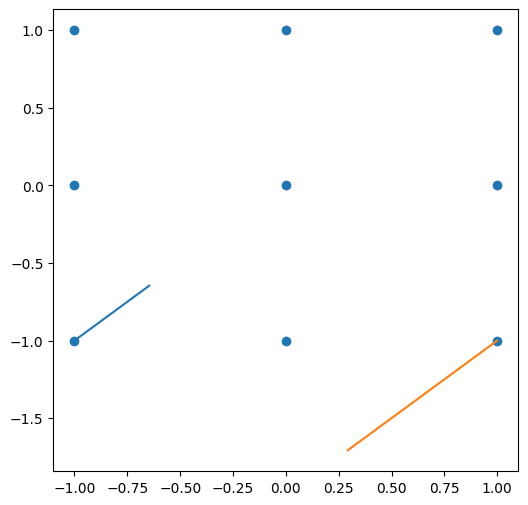

In [40]:
def one_form_to_vector_fieldBIS(self:MYMesh, omega):
    vector_field = np.zeros((len(bm.verts), 3))
    he:HEEdge
    for v in self.verts[0:2]:
        print("///////////////////////////")
        vec = np.zeros(3)
        v_area_inv = 1/self.vertex_attributes["area"][v.index]
        for f in v.link_faces:
            he = self.dict_vert2heedges[(f.verts[0].index, f.verts[1].index)]
            while he.vertex != v:
                he = he.next
            pi, pj, pk = he.vertex.co, he.next.vertex.co, he.next.next.vertex.co
            cij, cki = omega[he.edge.index], omega[he.next.next.index]
            f = he.face
            fc = self.face_vertex_to_facecorner[f][v]
            fc_area = self.facecorner_attributes["area"][fc.index]
            f_area = self.face_areas[f.index]
            pij_ortho = -np.cross(f.normal, he.edge.verts[1].co - he.edge.verts[0].co)
            if he.vertex != he.edge.verts[0]:
                pij_ortho = - pij_ortho
            pki_ortho = np.cross(f.normal, he.next.next.edge.verts[1].co - he.next.next.edge.verts[0].co)
            if he.next.next.verts[0] != he.vertex:
                pki_ortho = -pki_ortho
            u_v = v_area_inv * (fc_area/(2*f_area)) * (cij * pki_ortho - cki*pij_ortho)
            u_v = (cij * pki_ortho - cki*pij_ortho)
            vec = vec + u_v
            print(he.edge.verts[0].index, he.edge.verts[1].index, he.next.edge.verts[1].index)
            print(cij, pki_ortho)
            print(cki, pij_ortho)
            print(u_v)
        print(vec)
        vector_field[v.index] = vec
    return np.array(vector_field)
            
# v_rr = one_form_to_vector
# _fieldBIS(bm, w)

vector_field_to_plot = one_form_to_vector_fieldBIS(bm, w)
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(bm.co[:,0], bm.co[:,1])
for vec, pt in zip(vector_field_to_plot, bm.co):
    ax.plot([pt[0], pt[0] + vec[0]], [pt[1], pt[1] + vec[1]])
    



In [30]:
w[6]

-0.35355339059327373

In [51]:
bm.vertex_attributes["area"]

array([0.25, 0.25, 0.25, 0.25, 0.5 , 0.5 , 0.5 , 0.5 , 1.  ])

In [362]:
phi = [np.linalg.norm(v.co - bm.verts[8].co) for v in bm.verts]  # Euclidean distance from center vertex
phi = np.array(phi)
edges = np.array([
    [4, 0], [5, 1], [6, 3], [7, 2],
    [2, 4], [0, 5], [1, 6], [3, 7],
    [8, 7], [5, 8], [8, 4], [6, 8],
    [7, 6], [2, 8], [4, 5], [8, 1]
])

# Edge lengths
edge_lengths = np.linalg.norm(bm.co[edges[:, 1]] - bm.co[edges[:, 0]], axis=1)

# Gradient along edges
phi_gradients = (phi[edges[:, 1]] - phi[edges[:, 0]]) / edge_lengths

# Combine gradient magnitude with edge directions to produce the gradient vector field
edge_directions = (bm.co[edges[:, 1]] - bm.co[edges[:, 0]]) / edge_lengths[:, None]
gradient_field = phi_gradients[:, None] * edge_directions  # Vector field on edges

gradient_field  # Output the gradient field on edges



array([[ 0.        , -0.41421356,  0.        ],
       [ 0.41421356,  0.        ,  0.        ],
       [ 0.        ,  0.41421356,  0.        ],
       [-0.41421356,  0.        ,  0.        ],
       [-0.        ,  0.41421356, -0.        ],
       [-0.41421356, -0.        , -0.        ],
       [-0.        , -0.41421356, -0.        ],
       [ 0.41421356, -0.        , -0.        ],
       [ 0.        ,  1.        ,  0.        ],
       [-0.        , -1.        , -0.        ],
       [-1.        ,  0.        ,  0.        ],
       [ 1.        , -0.        , -0.        ],
       [ 0.        , -0.        ,  0.        ],
       [-0.70710678,  0.70710678, -0.        ],
       [ 0.        , -0.        ,  0.        ],
       [ 0.70710678, -0.70710678,  0.        ]])

In [364]:
tmp = d0 @ phi
for i, (g, e) in enumerate(zip(gradient_field, bm.edges)):
    vec = e.verts[1].co - e.verts[0].co
    # vec = vec / np.linalg.norm(vec)
    print(np.dot(vec, g), tmp[i])

0.41421356237309515 0.41421356237309515
0.41421356237309515 0.41421356237309515
0.41421356237309515 0.41421356237309515
0.41421356237309515 0.41421356237309515
-0.41421356237309515 -0.41421356237309515
-0.41421356237309515 -0.41421356237309515
-0.41421356237309515 -0.41421356237309515
-0.41421356237309515 -0.41421356237309515
1.0 1.0
-1.0 -1.0
1.0 1.0
-1.0 -1.0
0.0 0.0
-1.414213562373095 -1.4142135623730951
0.0 0.0
1.414213562373095 1.4142135623730951


array([[ 0.        , -0.41421356,  0.        ],
       [ 0.41421356,  0.        ,  0.        ],
       [ 0.        ,  0.41421356,  0.        ],
       [-0.41421356,  0.        ,  0.        ],
       [-0.        ,  0.41421356, -0.        ],
       [-0.41421356, -0.        , -0.        ],
       [-0.        , -0.41421356, -0.        ],
       [ 0.41421356, -0.        , -0.        ],
       [ 0.        ,  1.        ,  0.        ],
       [-0.        , -1.        , -0.        ],
       [-1.        ,  0.        ,  0.        ],
       [ 1.        , -0.        , -0.        ],
       [ 0.        , -0.        ,  0.        ],
       [-0.70710678,  0.70710678, -0.        ],
       [ 0.        , -0.        ,  0.        ],
       [ 0.70710678, -0.70710678,  0.        ]])

In [360]:


for attr in mesh.attributes:
    if attr.name.startswith("field"):
        mesh.attributes.remove(attr)

attr = mesh.attributes.new(name="field", type='FLOAT_VECTOR', domain='POINT')
attr.data.foreach_set('vector', (gradient_field).flatten())

RuntimeError: internal error setting the array

In [335]:
ex1f = np.array([ 4.57720057e-01,  2.49386724e-01,  3.32720057e-01,  3.74386724e-01,
        2.70220057e-01,  6.13276912e-04, -7.07720057e-01, -2.70220057e-01,
        2.70833334e-01, -2.70833333e-01, -2.08333333e-01, -2.70833334e-01,
       -6.25000002e-02, -5.41666667e-01, -1.04166667e-01,  4.37500000e-01])

coex1f = np.array([-0.10416667,  0.10416667,  0.02083333, -0.02083333, -0.62377344,
       -0.35416667,  0.35416667, -0.08333328,  0.22916667, -0.22916667,
        0.70833334, -0.22916667,  0.0625    ,  0.04166668,  0.10416667,
        0.0625    ])


v_exact = bm.one_form_to_vector_field(ex1f)
v_coexact = bm.one_form_to_vector_field(coex1f)
v_harmonic = bm.one_form_to_vector_field(harmonic_1form)
v_reconstructed = bm.one_form_to_vector_field(w)

for attr in mesh.attributes:
    if attr.name.startswith("field"):
        mesh.attributes.remove(attr)

attr = mesh.attributes.new(name="field", type='FLOAT_VECTOR', domain='POINT')
attr.data.foreach_set('vector', (v_exact + v_coexact).flatten())

In [291]:
def build_matrix_M(bm:MYMesh):
    d0 = bm._build_d0()
    d1 = bm._build_d1()
    star_0_inv = bm._build_hodge0(inverse=True)
    star_1 = bm._build_hodge1()
    star_2 = bm._build_hodge2()
    return d1.T @ star_2 @ d1 + star_1 @ d0 @ star_0_inv @ d0.T @ star_1


M = build_matrix_M(bm)
ce = w.copy()
# plt.imshow(M.todense())
# M@ce

In [294]:
sv = np.zeros(len(bm.verts))
sv[8] = -1
# sv[50] = 1
sv = sv 
sv

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.])

In [302]:
x = bm.one_form_to_vector_field(spsolve(M, h1 @ d0 @ sv))
# x = bm.one_form_to_vector_field(d0 @ exact_0form)

for attr in mesh.attributes:
    if attr.name.startswith("field"):
        mesh.attributes.remove(attr)
        
attr = mesh.attributes.new(name="field", type='FLOAT_VECTOR', domain='POINT')
attr.data.foreach_set('vector', (x).flatten())


In [265]:
spsolve(M, h1 @ d0 @ sv)

array([ 0.00384633, -0.01385006, -0.00277948,  0.00026812,  0.01845163,  0.09990118, -0.08175046, -0.01482509,  0.00188669, -0.43946343,  0.00214787,
       -0.42367803,  0.02603328,  0.12226342, -0.03139111, -0.00137526,  0.00365165,  0.03115951, -0.09899748, -0.01644238,  0.03440185, -0.09391013,
        0.03805341, -0.05930485, -0.08663546, -0.25153214, -0.09223488, -0.01898615, -0.03481819, -0.03945502, -0.0015979 , -0.02034545,  0.00073255,
        0.00330096,  0.00125139,  0.00834609, -0.00108325, -0.0154662 , -0.02450624, -0.02904781,  0.01775368, -0.04937619, -0.01497496,  0.00070102,
        0.00958144,  0.05918048, -0.10366277, -0.01904437,  0.01155842, -0.15446389,  0.01306281, -0.12675011,  0.02584063,  0.14776571, -0.05431032,
       -0.00716209,  0.0009321 ,  0.01183671, -0.04436306, -0.00812281,  0.13321646, -0.03859976,  0.14107829, -0.02157874, -0.13911731,  0.30378705,
       -0.11751632,  0.00952861, -0.04870914, -0.0186083 , -0.00878116, -0.04526892,  0.00330903, -0

In [101]:
star_1 = bm._build_hodge1()
star_1_inv = bm._build_hodge1(inverse=True)
d0 = bm._build_d0()


one_form

array([ 0.        ,  1.        ,  0.        , -1.        ,  0.        ,
        1.        ,  0.        , -1.        ,  0.        ,  0.        ,
       -1.        , -1.        ,  0.70710678,  0.70710678,  0.70710678,
        0.70710678])

In [100]:
res=spsolve(d0@d0.T + 1e-9*scipy.sparse.eye(16), star_1_inv @ M @ one_form)
res = res/np.linalg.norm(res)
res

array([ 0.23652498,  0.17739374, -0.23652496, -0.17739371,  0.17739375,
        0.23652498, -0.17739369, -0.23652496, -0.23652496, -0.23652494,
       -0.23652495, -0.23652493, -0.2956562 , -0.35478747, -0.29565618,
       -0.35478743])

In [282]:
custom_vf = np.zeros((len(bm.verts), 3))
for v in bm.verts:
    vec = np.array(v.co - bm.verts[8].co)
    length = np.linalg.norm(vec)
    if length > 1e-9:
        custom_vf[v.index] = vec/length

one_form = bm.vector_field_to_1form(custom_vf)
# custom_vf = bm.one_form_to_vector_field(one_form)
# custom_vf = custom_vf/np.linalg.norm(custom_vf, axis=1)[:,None]
for attr in mesh.attributes:
    if attr.name.startswith("field"):
        mesh.attributes.remove(attr)

attr = mesh.attributes.new(name="field", type='FLOAT_VECTOR', domain='POINT')
attr.data.foreach_set('vector', custom_vf.flatten())

sv = np.zeros(len(bm.verts))
sv[8] = 1
star1 = bm._build_hodge1()
star1_inv = bm._build_hodge1(inverse=True)
d0 = bm._build_d0()

print(star1 @ d0@sv)

print(one_form)

[ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1. -1.  1.  0.  0.  0.  0.]
[ 0.35355339  0.35355339  0.35355339  0.35355339 -0.35355339 -0.35355339
 -0.35355339 -0.35355339  0.5        -0.5         0.5        -0.5
  0.         -0.5         0.          0.5       ]


In [117]:
one_form = spsolve(M, star1 @ d0@sv)
custom_vf = bm.one_form_to_vector_field(one_form)
custom_vf = custom_vf/np.linalg.norm(custom_vf, axis=1)[:,None]
for attr in mesh.attributes:
    if attr.name.startswith("field"):
        mesh.attributes.remove(attr)

attr = mesh.attributes.new(name="field", type='FLOAT_VECTOR', domain='POINT')
attr.data.foreach_set('vector', custom_vf.flatten())


In [134]:

# Vertices coordinates
vertices = np.array([[-1., -1.,  0.],
                     [ 1., -1.,  0.],
                     [-1.,  1.,  0.],
                     [ 1.,  1.,  0.],
                     [-1.,  0.,  0.],
                     [ 0., -1.,  0.],
                     [ 1.,  0.,  0.],
                     [ 0.,  1.,  0.],
                     [ 0.,  0.,  0.]])

# Indices of the vertices defining each face
faces = np.array([[6, 7, 8],
                  [8, 2, 4],
                  [5, 4, 0],
                  [1, 8, 5],
                  [6, 3, 7],
                  [8, 7, 2],
                  [5, 8, 4],
                  [1, 6, 8]])

# Indices of the vertices defining each edge
edges = np.array([[4, 0],
                  [5, 1],
                  [6, 3],
                  [7, 2],
                  [2, 4],
                  [0, 5],
                  [1, 6],
                  [3, 7],
                  [8, 7],
                  [5, 8],
                  [8, 4],
                  [6, 8],
                  [7, 6],
                  [2, 8],
                  [4, 5],
                  [8, 1]])

def vertex_field_to_1form(vector_field, edges, vertices):
    num_edges = edges.shape[0]
    ce = np.zeros(num_edges, dtype=float)
    for i, edge in enumerate(edges):
        v1 = vertices[edge[0]]
        v2 = vertices[edge[1]]
        vec1 = vector_field[edge[0]]
        vec2 = vector_field[edge[1]]
        edge_vector = v2 - v1
        edge_vector /= np.linalg.norm(edge_vector)  # Normalize the edge vector
        ce[i] = 0.5 * (np.dot(vec1, edge_vector) + np.dot(vec2, edge_vector))
    return ce
def solve_poisson(A, b):
    # Solve the Poisson equation A x = b
    return spsolve(A, b)

vector_field = custom_vf
one_form = bm.vector_field_to_1form(custom_vf)

d0, d1, hodge0, hodge1, hodge2 = bm.construct_dec_operators()
hodge1_inv = bm._build_hodge1(inverse=True)
# hodge1 = _build_hodge_star1_form(bm)
one_form = bm.vector_field_to_1form(vector_field)

# Curl-free Component
laplace0 = d0.T @ hodge1 @ d0
phi = solve_poisson(laplace0, d0.T @ hodge1 @ one_form)
grad_component = d0 @ phi

# Divergence-free Component
laplace1 = d1 @ hodge1_inv @ d1.T
psi = solve_poisson(laplace1, d1 @ one_form)
rot_component = d1.T @ psi

# Harmonic Component
harmonic_component = one_form - grad_component - rot_component

vector_grad = bm.one_form_to_vector_field(grad_component)
vector_rot = bm.one_form_to_vector_field(rot_component)
vector_harmonic = bm.one_form_to_vector_field(harmonic_component)


In [137]:
vector_harmonic

array([[-0.02588835,  0.02588835,  0.        ],
       [-0.03560108, -0.01995447,  0.        ],
       [-0.03425221, -0.02130334,  0.        ],
       [-0.02588835,  0.02588835,  0.        ],
       [-0.0107233 ,  0.01455714,  0.        ],
       [-0.05866616,  0.0107233 ,  0.        ],
       [-0.0107233 ,  0.01699949,  0.        ],
       [-0.05622381,  0.0107233 ,  0.        ],
       [ 0.01011003, -0.01011003,  0.        ]])

In [17]:
sv = np.zeros(len(bm.verts))
dict_divergences = {0:1, 600:-1}
dict_divergences = {5:-1, 7:1}
for k in dict_divergences:
    sv[k] = dict_divergences[k]

area_weight = bm.vertex_attributes["area"] / np.sum(bm.vertex_attributes["area"])
cte = np.sum(area_weight * sv)
sum_weight = np.sum([area_weight[k] for k in dict_divergences])
cte = cte / sum_weight
for k in dict_divergences:
    sv[k] = dict_divergences[k] - cte

print(np.sum(area_weight * sv))

# for k in dict_divergences:
#     print(sv[k])
#     sv[k] = sv[k] - cte
#     print(sv[k])

# sv[0] = -sv[600] * area_weight[600]/area_weight[0]

# sv = sv - cte / (len(sv) * area_weight)
# print(np.sum(area_weight * sv))

star_1 = bm._build_hodge1()
d0 = bm._build_d0()

RHS = star_1 @ d0 @ sv

AAT = M @ M.T
y = spsolve(AAT, RHS)
ce = M.T @ y


ce = scipy.sparse.linalg.spsolve(M, RHS)

field = bm.one_form_to_vector_field(ce)
for attr in mesh.attributes:
    if attr.name.startswith("field"):
        mesh.attributes.remove(attr)

attr = mesh.attributes.new(name="field", type='FLOAT_VECTOR', domain='POINT')
attr.data.foreach_set('vector', field.flatten())

for k in dict_divergences:
    draw_sphere(bm.verts[k].co, 0.025, f"divergence_{k}")

0.0


In [70]:
ce

array([ 0.53011897, -0.06979398, -0.01403012,  0.55629418,  0.01128472,
        0.70047478, -0.015625  ,  0.02398904, -0.1226808 ,  0.08752594,
        0.39466645,  0.00569476,  0.08319736,  0.39830519,  0.23874816,
        0.02537794])

field
field.001
position
field.002
field.003
field.004
field.005
field.006
field.007
field.008
.select_vert
.edge_verts
.select_edge
.select_poly
sharp_face
.corner_vert
.corner_edge
UVMap


In [31]:
np.sort(M@ce - RHS)

array([-3.50275364e-14, -2.74225087e-14, -1.47659662e-14, -7.18869408e-15,
       -5.53723734e-15, -4.44089210e-15, -3.49720253e-15, -7.77156117e-16,
        2.49800181e-15,  3.33066907e-15,  4.24660307e-15,  4.71844785e-15,
        8.32667268e-15,  9.60342916e-15,  2.80331314e-14,  3.06421555e-14])

In [32]:
field

array([[-0.03394863, -0.14724056,  0.        ],
       [ 0.02292354,  0.02388801,  0.        ],
       [-0.00021716, -0.00118163,  0.        ],
       [ 0.04334599,  0.00231299,  0.        ],
       [-0.0025086 , -0.0580836 ,  0.        ],
       [-0.03555065,  0.00866444,  0.        ],
       [ 0.00843692,  0.03862756,  0.        ],
       [ 0.02130115,  0.01962411,  0.        ],
       [ 0.02793752, -0.00512627,  0.        ]])

In [118]:
Md = M.todense()

[ 1  1  1 ... 33 34 34]


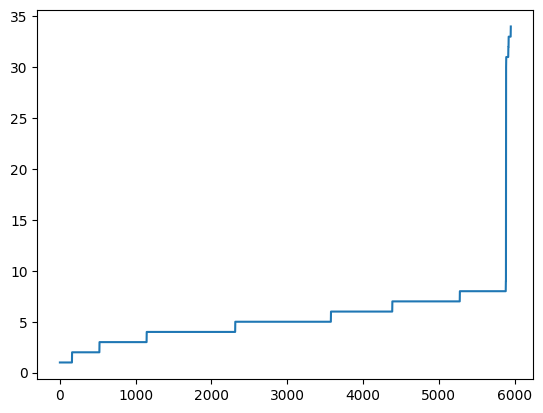

In [120]:
non_zero_per_row = np.array([np.sum(np.abs(Md[i]>1e-8)) for i in range(len(Md))])
print(np.sort(non_zero_per_row))
plt.plot(np.sort(non_zero_per_row))

In [121]:
np.mean(non_zero_per_row)

5.338037634408602